In [37]:
# %pip install torchvision

In [1]:
import eda_helpers as eda

/home/ubuntu/eda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATASET: https://huggingface.co/datasets/sasha/dog-food

In [2]:
# Variables
DATASET_PATH = 'sasha/dog-food'
LABELS = ["dog", 'food']
GROUP_COL = 'group'  # unfortunatelly there are no 4-class specification

In [ ]:
data = eda.download_dataset(DATASET_PATH, 'train')
data['group'] = 0
data.head()

Generating test split: 100%|██████████| 900/900 [00:00<00:00, 3405.55 examples/s]


,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0


In [7]:
data.isna().sum(axis=0)
# no misses

image    0
label    0
group    0
dtype: int64

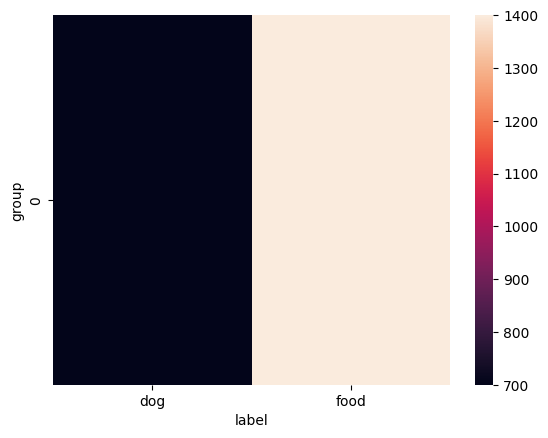

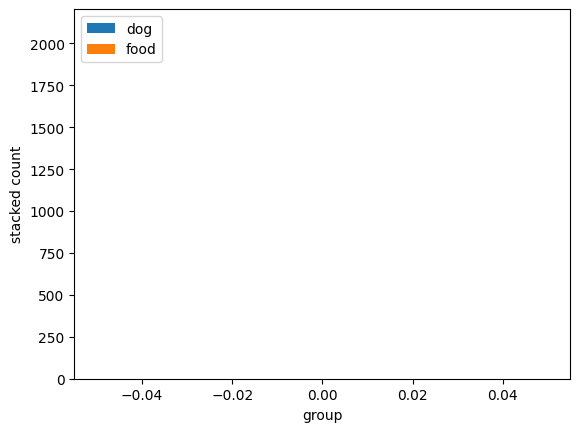

In [8]:
eda.twod_label_distribution(data, 'label', GROUP_COL, LABELS)

Еды больше и жаль что нет разделения по 4 классам

In [9]:
DOMAIN = data.group.unique()

In [ ]:
data.image.apply(lambda x: x.size).unique()
# есть разные размеры фото - очень много

array([(300, 470), (408, 612), (778, 990), (929, 1104), (612, 437),
       (623, 900), (242, 288), (612, 612), (1000, 750), (150, 150),
       (217, 325), (236, 374), (236, 254), (612, 408), (438, 612),
       (612, 457), (1024, 683), (900, 603), (612, 432), (465, 700),
       (445, 612), (300, 308), (900, 600), (405, 612), (800, 602),
       (400, 524), (450, 320), (804, 1200), (437, 612), (457, 612),
       (380, 295), (365, 302), (400, 237), (422, 562), (407, 612),
       (120, 156), (320, 240), (1205, 904), (540, 720), (1280, 1232),
       (1300, 866), (236, 248), (480, 360), (450, 349), (612, 407),
       (167, 250), (377, 386), (462, 612), (1035, 900), (510, 341),
       (389, 260), (1300, 957), (550, 413), (406, 612), (236, 353),
       (583, 573), (500, 500), (700, 427), (289, 269), (612, 399),
       (273, 343), (300, 300), (660, 292), (1600, 1067), (1158, 1104),
       (459, 612), (796, 1280), (236, 314), (565, 480), (612, 409),
       (700, 933), (900, 565), (236, 354), (450

In [14]:
data.image.apply(lambda x: x.size[1]).median()


np.float64(408.0)

In [15]:
data['image'] = data['image'].map(lambda x: x.resize((400, 400), eda.Image.Resampling.LANCZOS))

In [16]:
data.image.apply(lambda x: x.size).unique()
# теперь норм

array([(400, 400)], dtype=object)

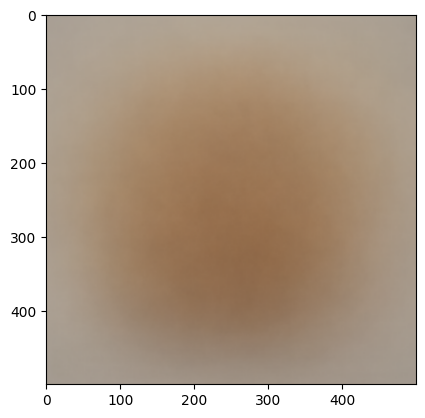

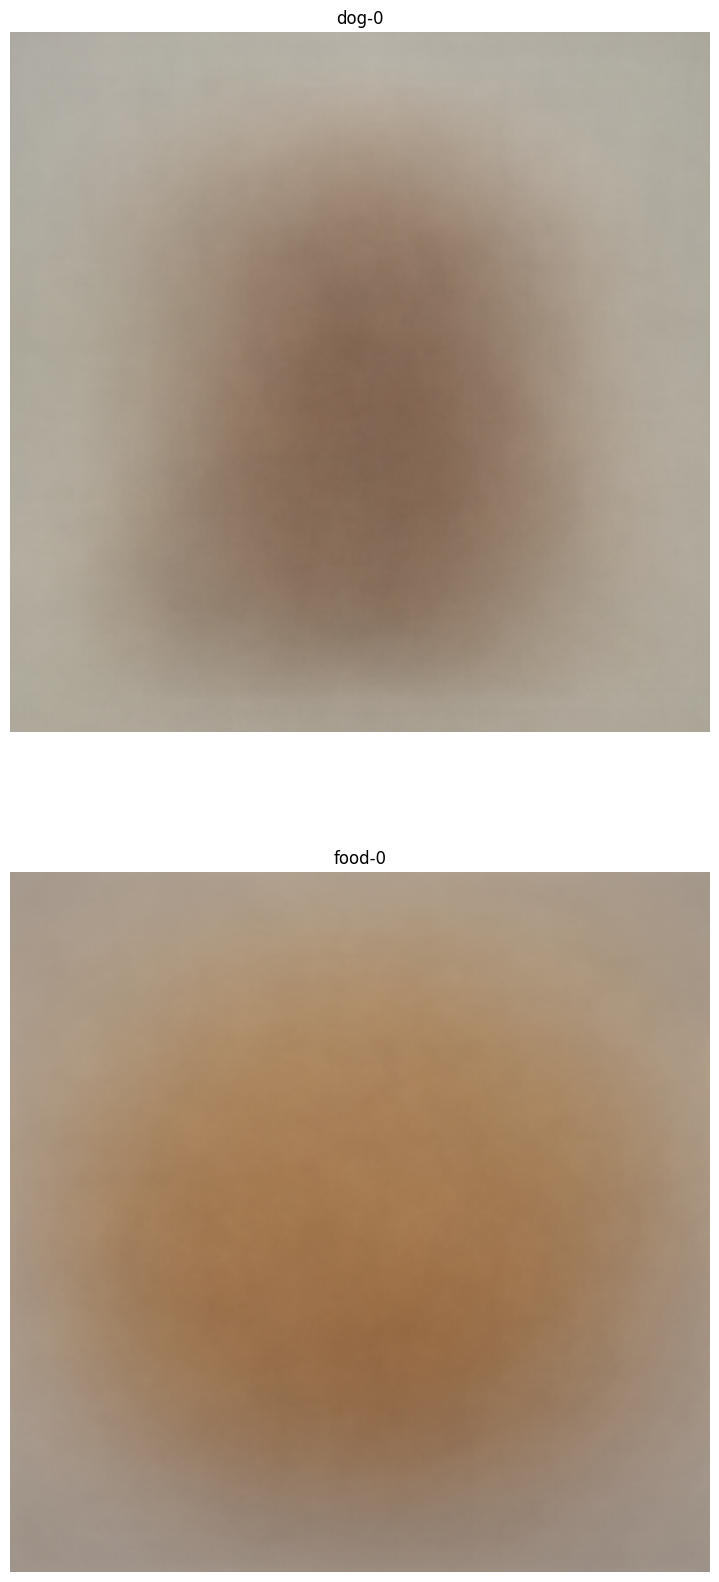

In [17]:
eda.draw_image_over_groups(data, lambda x: eda.Image.fromarray(eda.find_mean_photo(x)).resize((500, 500)), DOMAIN, LABELS, GROUP_COL, 'label', 'image')

Среднее ничего не дало, поэтому идем дальше - здесь все хорошо

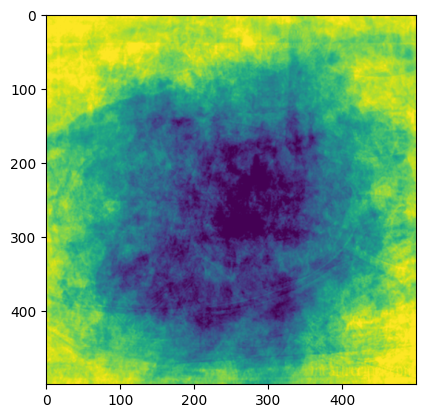

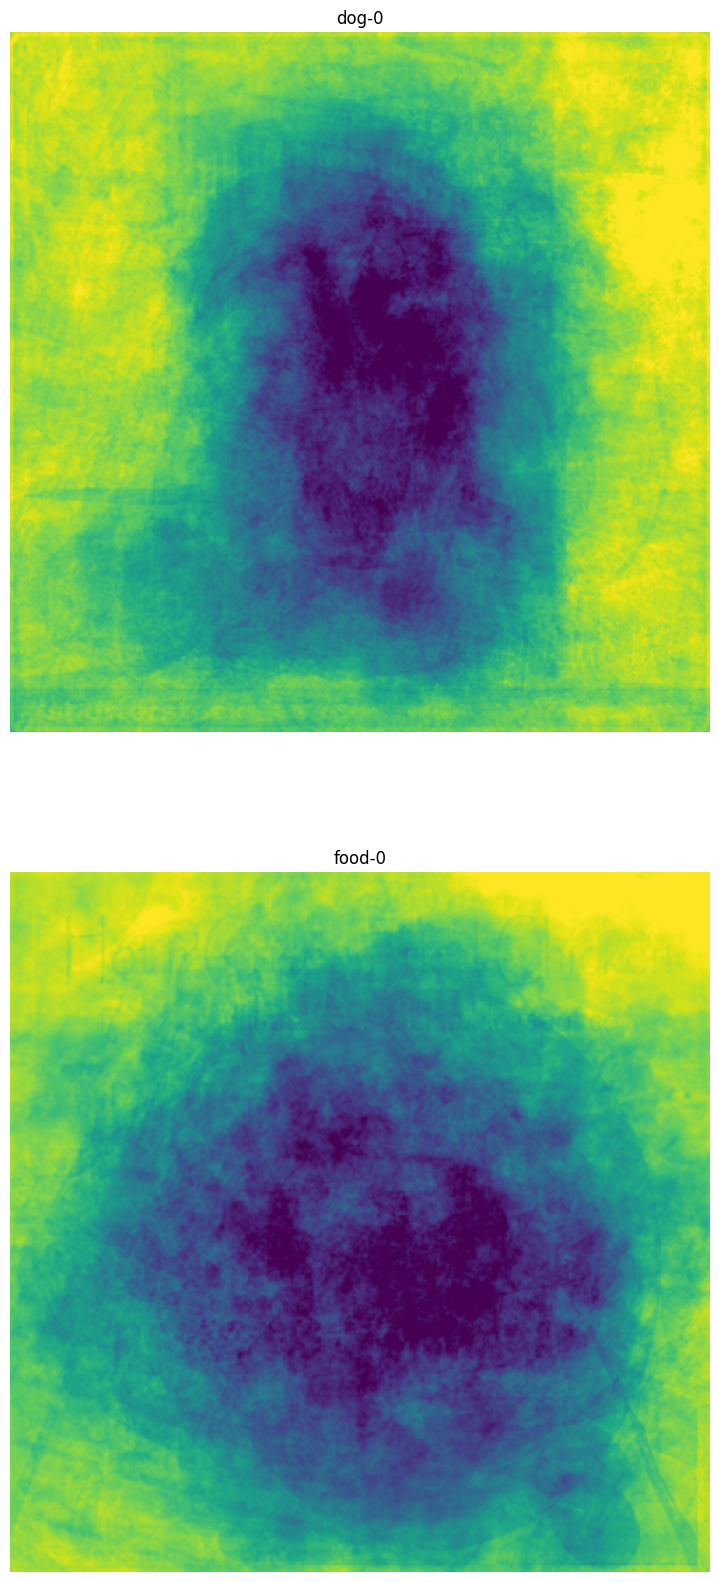

In [18]:
eda.draw_image_over_groups(data, lambda x: eda.Image.fromarray(eda.find_eigenphoto(x)).resize((500, 500)), DOMAIN, LABELS, GROUP_COL, 'label', 'image', random=True)

тоже ничего не дало, хорошо (с тем что у меня нет 4-рех классов), идем дальше

In [22]:
# eda.see_samples(data, LABELS, DOMAIN, 5, 'image', GROUP_COL, 'label')

единственно, там была серая собака, как будто у еды есть ограниченный цвет (маффины + курица примерно теплых цветов). Это может плохо сказываться

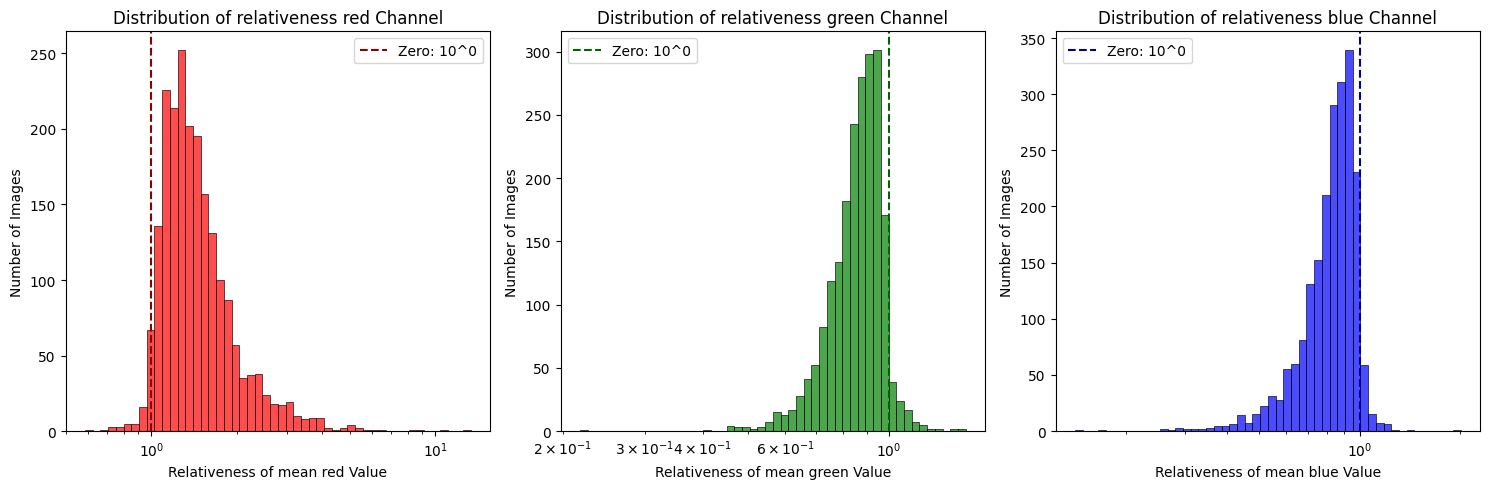

In [23]:
eda.draw_color_distrib(*eda.get_colors(eda.all_generator(data, 'image')))

перекос в красный видимо из-за еды

dog-0


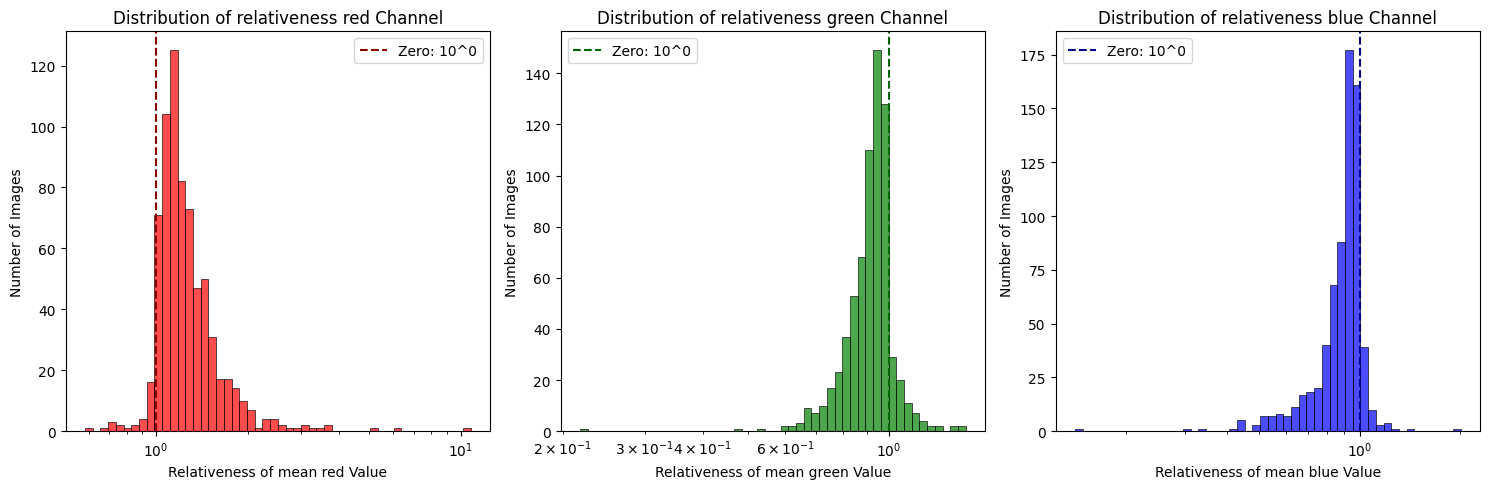

food-0


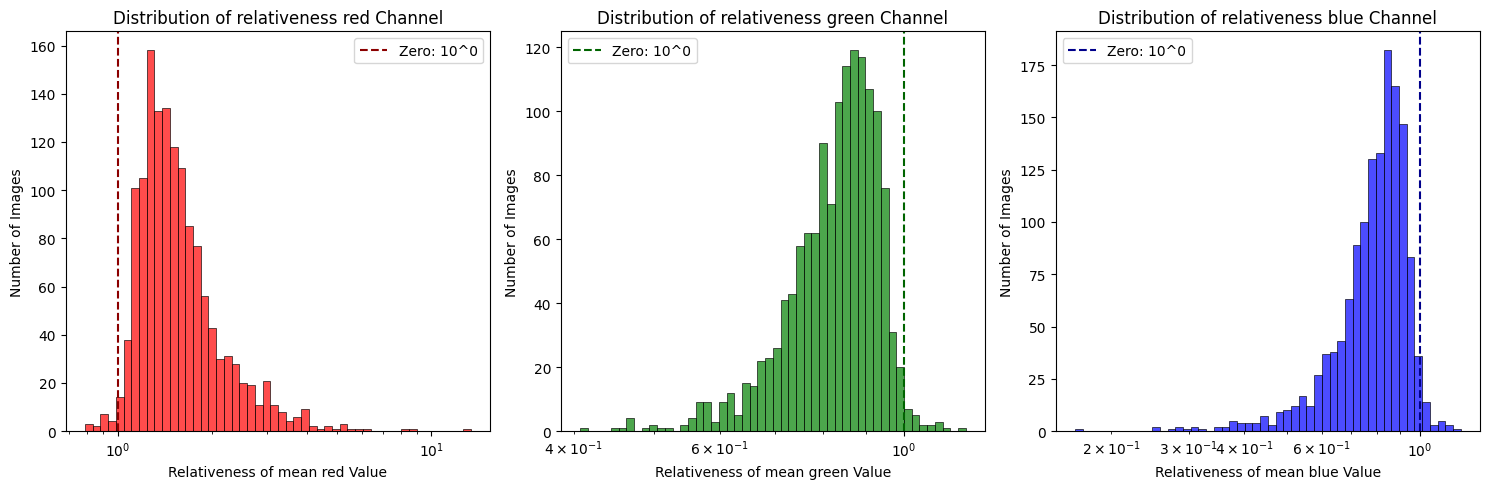

In [24]:
for label, label_name in enumerate(LABELS):
    for domain in data.group.unique():
        print("{}-{}".format(label_name, domain))
        eda.draw_color_distrib(*eda.get_colors(eda.single_generator(data, 'image', GROUP_COL, 'label', domain, label)))

собаки и правда меньше перекошены по красному. поэтомунужно либо все отеплить, либо охолодить еду

Можно посмотреть также на пару добученных моделей к датасету. Начнем с той, которая не роняет мой ноутбук (потом еще найду хост)

In [25]:
import psutil
import torch
device = torch.device('cpu')
torch.set_num_threads(psutil.cpu_count())

In [26]:
# Usage
model = eda.models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = eda.nn.Linear(model.classifier[3].in_features, len(LABELS))

transform = eda.transforms.Compose([
        eda.transforms.Resize((64, 64)),  # Small images for CPU
        eda.transforms.ToTensor(),
        eda.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_loader, val_loader = eda.create_cpu_friendly_dataloaders(data, transform)
eda.cpu_friendly_train(device, model, train_loader, val_loader, epochs=10)

/home/ubuntu/eda/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/eda/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
  Batch 0, Loss: 0.987, Acc: 25.00%
  Batch 10, Loss: 0.696, Acc: 60.80%
  Batch 20, Loss: 0.544, Acc: 71.73%
  Batch 30, Loss: 0.480, Acc: 76.21%
  Batch 40, Loss: 0.443, Acc: 79.27%
  Batch 50, Loss: 0.429, Acc: 80.02%
  Batch 60, Loss: 0.396, Acc: 81.86%
Epoch 1 Complete:
  Train Loss: 0.397, Train Acc: 81.90%
  Val Acc: 91.50%
--------------------------------------------------
Epoch 2/10
  Batch 0, Loss: 0.078, Acc: 100.00%
  Batch 10, Loss: 0.201, Acc: 91.48%
  Batch 20, Loss: 0.161, Acc: 93.45%
  Batch 30, Loss: 0.163, Acc: 93.95%
  Batch 40, Loss: 0.153, Acc: 94.66%
  Batch 50, Loss: 0.161, Acc: 94.24%
  Batch 60, Loss: 0.154, Acc: 94.57%
Epoch 2 Complete:
  Train Loss: 0.161, Train Acc: 94.20%
  Val Acc: 89.50%
--------------------------------------------------
Epoch 3/10
  Batch 0, Loss: 0.026, Acc: 100.00%
  Batch 10, Loss: 0.112, Acc: 96.02%
  Batch 20, Loss: 0.117, Acc: 95.83%
  Batch 30, Loss: 0.114, Acc: 95.36%
  Batch 40, Loss: 0.106, Acc: 96.04%
  Batch 50, L

около 90% - что-то пошло не так. Хотя, как разнообразие, можно взять и его тоже, главное чтобы FL не сильно падало. С другой стороны - нет. Классы слишком хорошо разделимы

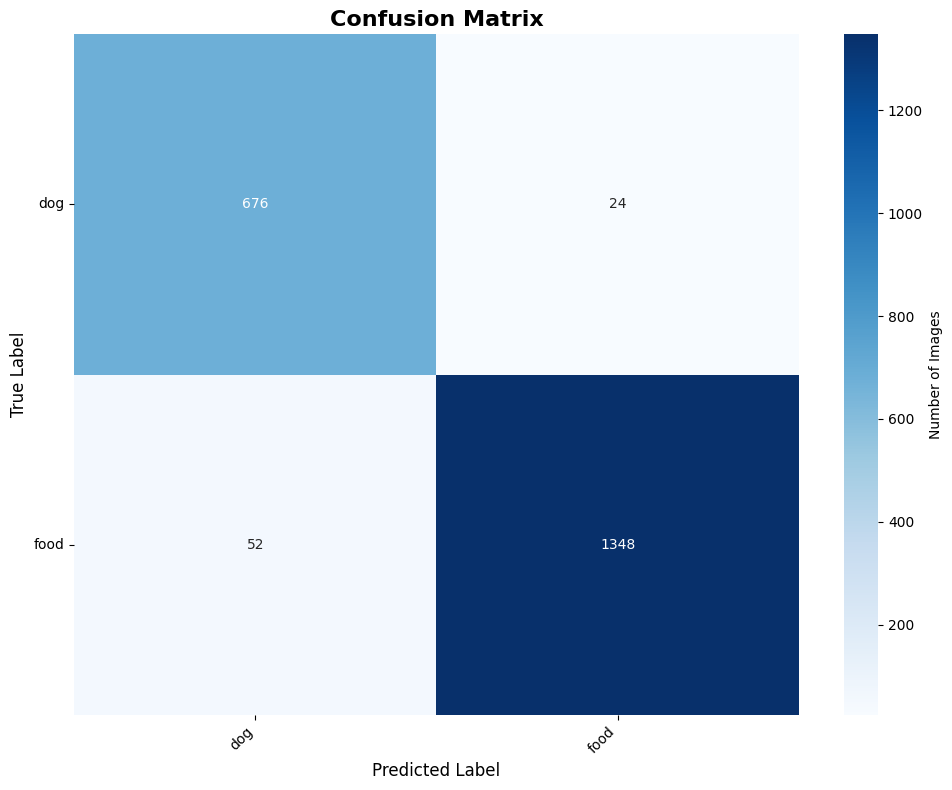

array([[ 676,   24],
       [  52, 1348]])

0:


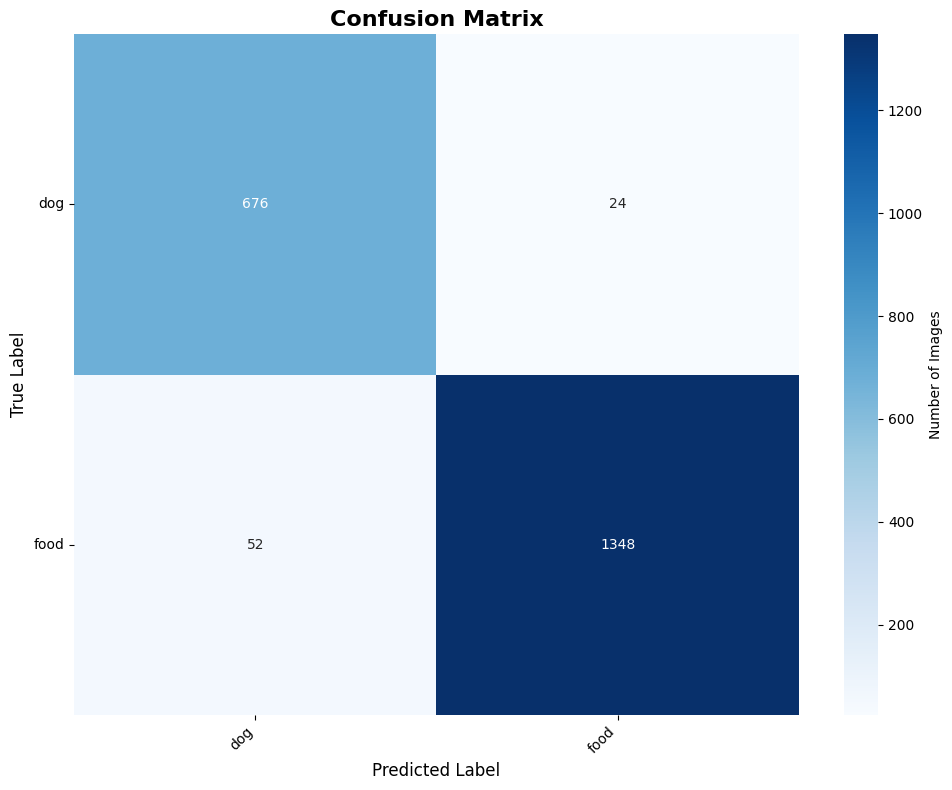

array([[ 676,   24],
       [  52, 1348]])

In [27]:
val_dataset = eda.DataFrameImageDataset(data, "image", "label", transform)
val_loader = eda.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
predictions, targets, probabilities = eda.evaluate_model(model, val_loader, device)
cm = eda.plot_confusion_matrix(targets, predictions, LABELS)
display(cm)

for domain in DOMAIN:
    print(domain, end=':\n')
    val_dataset = eda.DataFrameImageDataset(data[data[GROUP_COL] == domain], "image", "label", transform)
    val_loader = eda.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    
    
    predictions, targets, probabilities = eda.evaluate_model(model, val_loader, device)
    cm = eda.plot_confusion_matrix(targets, predictions, LABELS)
    display(cm)

In [29]:
# eda.visualize_errors(data, targets, predictions, probabilities, LABELS)

In [ ]:
import importlib

importlib.reload(eda)
